In [1]:
from plotnine import *
import geopandas as gp
from shapely.geometry import Point
import pandas as pd
import numpy as np
from pydantic import BaseModel

First of all, let's check the most common geo-data formats:

- SHAP: First up in our parade of geo data formats is Shapefile (SHP), the old faithful of the geo world. But you’ll need a complete set of three files that are mandatory to make up a shapefile. The three required files are: .SHP for geometry, .SHX is the shape index position and .DBF is the attribute data.

- GeoJSON:  It’s all about simplicity and web-friendliness, perfect for those who love to mingle with JavaScript and web mapping.

- KML: (Keyhole Markup Language), the go-to for Google Earth enthusiasts.

[Some more detailed context regarding geo data formats](https://gisgeography.com/gis-formats/)

We are going to load the Spanish geo data at Province level, in Shap format.

Before loading the data, let's create some functions in order to filter the data into the coordinates we may desire.

In [2]:
def filter_shp_peninsular_data(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["acom_name"] != "Canarias"]

def filter_df_based_on_shp(df: pd.DataFrame, shp_file: gp.GeoDataFrame) -> pd.DataFrame:
    list_included = []
    for _, df_row in df.iterrows():
        for _, shp_row in shp_file.iterrows():
            if shp_row["geometry"].contains(df_row["geometry"]):
                list_included.append(df_row)
    return pd.DataFrame(list_included)

We create a super basic model for coordinates.

In [3]:
class Coords(BaseModel):
    lat: float
    lng: float

## Download SHAP Spanish map polygon data

Download the Spain GIS map in Shap format. Then filter the peninsular box in order to make the plot easier.

In [12]:
FILE_PATH = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-spain-provincia-millesime/exports/shp'

spain_gis_map = gp.read_file(FILE_PATH)
peninsular_gis_map = filter_shp_peninsular_data(spain_gis_map)

## Generate random *Stations* data

In [5]:
np.random.seed(12345)

# Madrid, Barcelona, Malaga coords
all_coords = [Coords(lat=40.4168, lng=-3.7038), Coords(lat=41.3851, lng=2.1734), Coords(lat=36.719444, lng=-4.420000)]

# Generate random stations around the given cities
list_stations = []
main_size = 10
for coord in all_coords:
    list_stations.append(np.random.normal(loc=[coord.lng, coord.lat], scale=[0.3, 0.3], size=(main_size, 2)))

# Generate spread andom stations around a center point
spread_center_coord = Coords(lat=40.4168, lng=-3.7038)
spread_size = 30
list_stations.append(np.random.normal(loc=[spread_center_coord.lng, spread_center_coord.lat], scale=[2, 2], size=(spread_size, 2)))

# Concat all stations
coords = np.vstack((list_stations))

# Final Df
stations_geo_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "geometry": [Point(xy) for xy in zip(coords[:, 0], coords[:, 1])]
})

Filter out generated Stations outside the land

In [6]:
stations_geo_df = filter_df_based_on_shp(stations_geo_df, peninsular_gis_map)

## Generate random **Alerts** data

In [7]:
list_alerts = []
main_size = 100
for coord in all_coords:
    list_alerts.append(np.random.normal(loc=[coord.lng, coord.lat], scale=[3, 3], size=(main_size, 2)))

coords = np.vstack((list_alerts))

# Generating random alerts_solved
alert_solved = np.random.choice([True, False], size=main_size*len(all_coords), p=[0.5, 0.5])

alerts_geo_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "geometry": [Point(xy) for xy in zip(coords[:, 0], coords[:, 1])],
    "alert_solved": alert_solved
})


Filter out generated Stations outside the land

In [8]:
alerts_geo_df = filter_df_based_on_shp(alerts_geo_df, peninsular_gis_map)

## Plots

We can create customizable themes for Plotnine. So we create a reusable one.

In [9]:
custom_theme = (
    theme_bw() 
    + theme(legend_position = "bottom",
         legend_key_size = 10,
         legend_text = element_text(size=8),
         panel_grid_major_x = element_blank(),
         panel_grid_major_y = element_blank(),
         panel_border = element_blank(),
         plot_title = element_text(hjust = 2, size=18, color="black", family="Times", vjust=1, margin={"b": 18}),
         plot_subtitle = element_text(size=8, hjust=0, weight="italic", color="black"),
         axis_title = element_blank(),
         axis_text = element_blank(),
         axis_ticks = element_blank(),
         text = element_text(family = "Times", size=6, weight="bold"),
         panel_background = element_rect(fill = "#fffbf8"),
    )
)

Plot the stations and alerts on the Spanish map

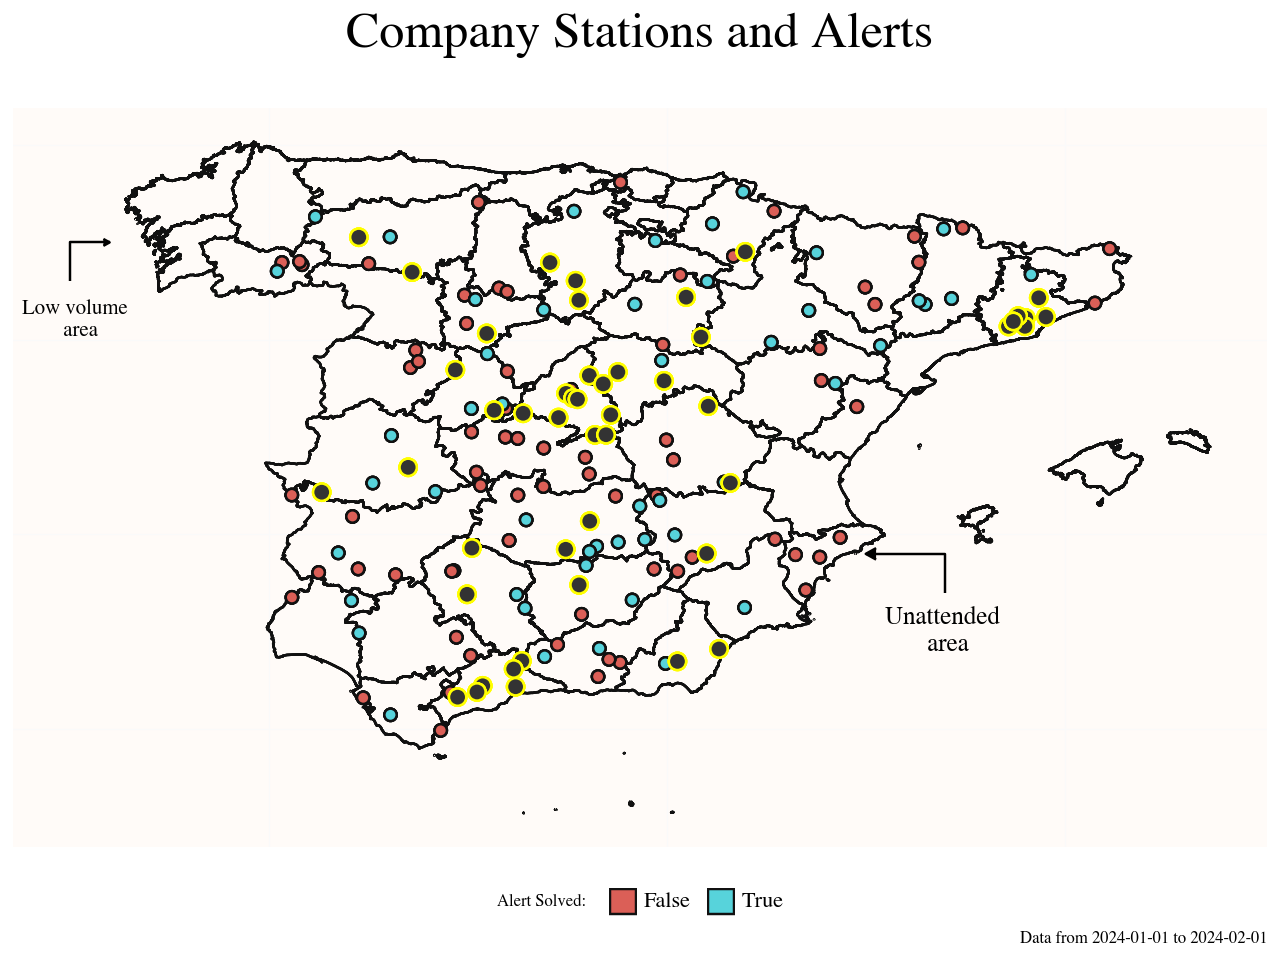

In [10]:
(
    ggplot()
    + geom_map(peninsular_gis_map, fill=None)
    + geom_map(alerts_geo_df, aes(fill="alert_solved"), size=2)
    + geom_map(stations_geo_df, colour="yellow", size=3)
    + labs(
        title="Company Stations and Alerts",
        caption = "Data from 2024-01-01 to 2024-02-01",
        fill="Alert Solved: "
    )
    + custom_theme
    #+ stat_function(data=pd.DataFrame({"x": [-5,-10], "y": [42,55]}), fun=np.sin)
    + annotate("path", x=[-9.5, -10, -10], y=[42.5, 42.5, 42], arrow=arrow(length=0.03, type="closed", ends="first", angle=35))
    + annotate("text", x=-9.9, y=41.5, label="Low volume \n area", size=7.5)
    + annotate("path", x=[0, 1, 1], y=[38.5, 38.5, 38], arrow=arrow(length=0.05, type="closed", ends="first", angle=35))
    + annotate("text", x=1, y=37.5, label="Unattended \n area", size=9)
)

We are now ploting the majority category by each quadrant.

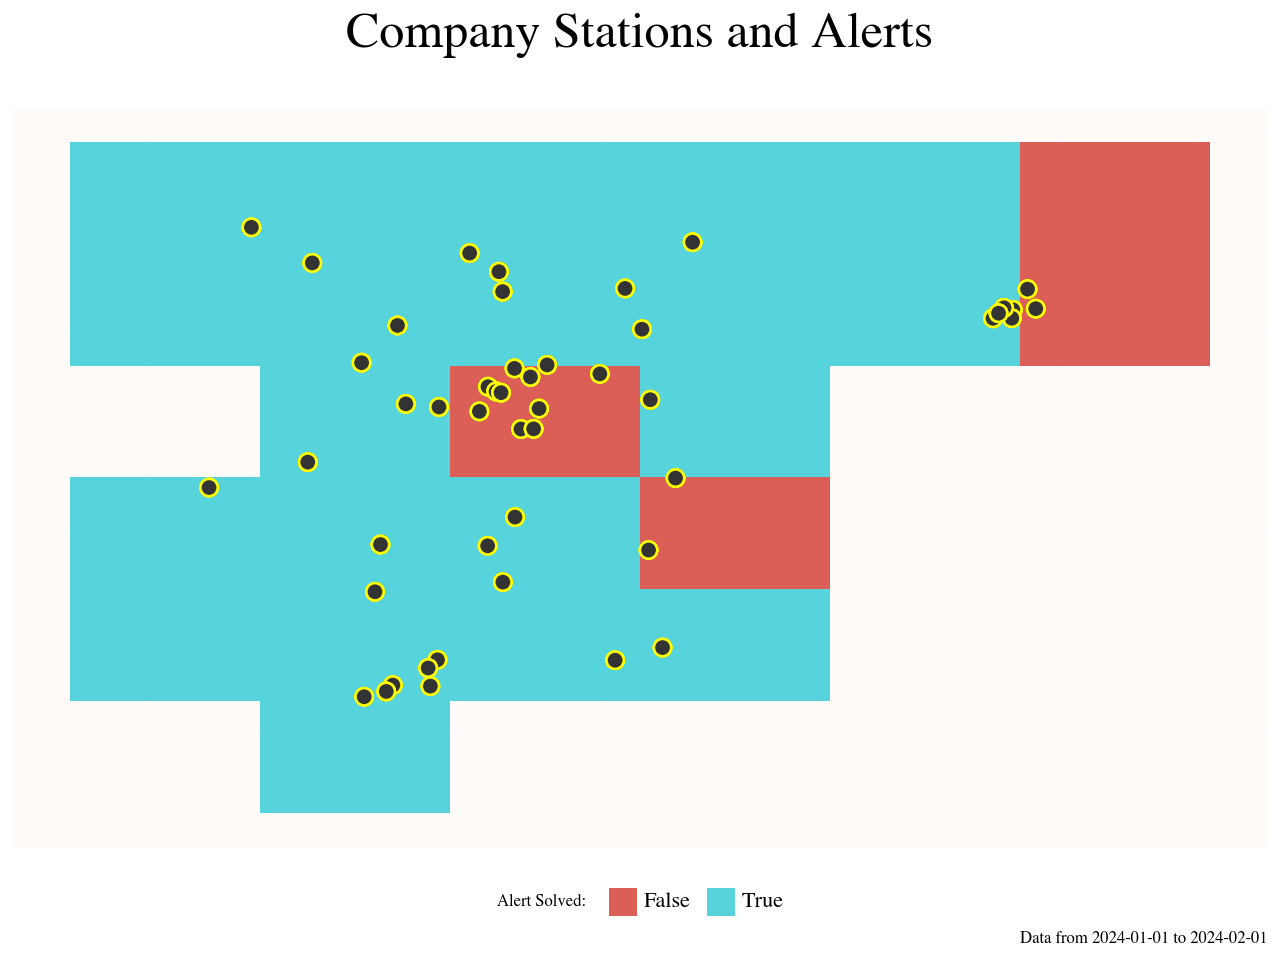

In [11]:
n_bins = 5

(
    ggplot()
    + geom_bin2d(alerts_geo_df, aes(x="x", y="y", fill="alert_solved"), bins = n_bins)
    + geom_map(stations_geo_df, colour="yellow", size=3)
    + labs(
        title="Company Stations and Alerts",
        caption = "Data from 2024-01-01 to 2024-02-01",
        fill="Alert Solved: "
    )
    + custom_theme
)